In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read in CSV
train_pd = pd.read_csv('train.csv')
test_pd = pd.read_csv('test.csv')

# Convert string representation of list to actual list of floats
train_pd['features'] = train_pd['features'].apply(lambda x: [float(i) for i in x.strip('[]').split(',')])
test_pd['features'] = test_pd['features'].apply(lambda x: [float(i) for i in x.strip('[]').split(',')])

x_train = torch.from_numpy(np.array(train_pd['features'].values.tolist(), np.float32))
y_train = torch.from_numpy(np.array(train_pd['outcome'].values.tolist(), np.int64))

x_test = torch.from_numpy(np.array(test_pd['features'].values.tolist(), np.float32))
y_test = torch.from_numpy(np.array(test_pd['outcome'].values.tolist(), np.int64))

# Make sure the data is zero-indexed
y_train = y_train - 1
y_test = y_test - 1
print(y_train.unique())

tensor([0, 1, 2, 3, 4])


In [3]:
print(x_train.shape, y_train.shape)

torch.Size([125973, 113]) torch.Size([125973])


In [4]:
from torch.utils.data import Dataset, DataLoader
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
train_dataset = MyDataset(x_train, y_train)
test_dataset = MyDataset(x_test, y_test)

In [5]:
class myNeuralNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.ln1 = nn.Linear(input_size, 128)
        self.ln2 = nn.Linear(128, 64)
        self.ln3 = nn.Linear(64, 32)
        self.ln4 = nn.Linear(32, 5)
    def forward(self, x):
        x = F.relu(self.ln1(x))
        x = F.relu(self.ln2(x))
        x = F.relu(self.ln3(x))
        x = self.ln4(x)
        x = F.softmax(x, dim=-1)
        return x

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
def training_loop(n_epochs, model, lr, batch_size):
    model = model.to(device)

    batch_size = batch_size
    num_epochs = n_epochs
    lr = lr
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fcn = nn.CrossEntropyLoss()

    train_loss = []
    test_loss = []
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode

        # Initialize variables to store the total loss for this epoch
        total_train_loss = 0
        total_test_loss = 0
        correct_predictions = 0
        total_predictions = 0
        # Training loop
        for batch_id, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)  # Move the data to the device that is used
            opt.zero_grad()  # Zero the gradients
            output = model(x)  # Forward pass
            loss = loss_fcn(output, y)  # Compute the loss

            total_train_loss += loss.item()  # Accumulate the loss
            _, predicted = torch.max(output.data, 1)  # Get the predicted classes
            total_predictions += y.size(0)
            correct_predictions += (predicted == y).sum().item()
            loss.backward()  # Backward pass
            opt.step()  # Update the parameters

        # Store the average training loss for this epoch
        train_loss.append(total_train_loss / len(train_loader))
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch + 1} - Train Accuracy: {correct_predictions / total_predictions}")
        # Validation loop
        model.eval()  # Set the model to evaluation mode
        correct_predictions = 0
        total_predictions = 0
        with torch.no_grad():  # No need to compute gradients during validation
            for batch_id, (x, y) in enumerate(test_loader):
                x, y = x.to(device), y.to(device)  # Move the data to the device that is used
                output = model(x)  # Forward pass
                loss = loss_fcn(output, y )  # Compute the loss
                total_test_loss += loss.item()  # Accumulate the loss
                _, predicted = torch.max(output.data, 1)
                total_predictions += y.size(0)
                correct_predictions += (predicted == y).sum().item()

        # Store the average validation loss for this epoch
        test_loss.append(total_test_loss / len(test_loader))

        # Print the losses every 5 epochs
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch + 1} - Train Loss: {train_loss[-1]}, Test Loss: {test_loss[-1]}")
            print(f"Epoch {epoch + 1} - Test Accuracy: {correct_predictions / total_predictions}")

        # Save the best model so far
        if epoch == 0 or test_loss[-1] < np.min(test_loss[:-1]):
            best_model = model
            best_epoch = epoch

        # Early stopping
        if epoch - best_epoch >= 30:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    # Plot the training and validation losses
    plt.plot(train_loss, label="Train Loss")
    plt.plot(test_loss, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Losses")
    plt.show()

    return best_model

In [11]:
input_size = x_train.shape[1]
models = myNeuralNet(input_size)
best_model = training_loop(10, models, 0.004, 128)

Epoch 5 - Train Accuracy: 0.9747723718574616
Epoch 5 - Train Loss: 0.9300287121443579, Test Loss: 1.1809837797940788
Epoch 5 - Test Accuracy: 0.7229418026969482
Epoch 10 - Train Accuracy: 0.9740817476760893
Epoch 10 - Train Loss: 0.9307262445464352, Test Loss: 1.1771779585692843
Epoch 10 - Test Accuracy: 0.7267565649396736


In [12]:
# Deeper MLP
class myDeeperNeuralNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.ln1 = nn.Linear(input_size, 128)
        self.ln2 = nn.Linear(128, 64)
        self.ln3 = nn.Linear(64, 64)
        self.ln4 = nn.Linear(64, 64)
        self.ln5 = nn.Linear(64, 32)
        self.ln6 = nn.Linear(32, 16)
        self.ln7 = nn.Linear(16, 8)
        self.ln8 = nn.Linear(8, 5)
    def forward(self, x):
        x = F.relu(self.ln1(x))
        x = F.relu(self.ln2(x))
        x = F.relu(self.ln3(x))
        x = F.relu(self.ln4(x))
        x = F.relu(self.ln5(x))
        x = F.relu(self.ln6(x))
        x = F.relu(self.ln7(x))
        x = self.ln8(x)
        x = F.softmax(x, dim=-1)
        return x

Epoch 5 - Train Accuracy: 0.09252776388591206
Epoch 5 - Train Loss: 1.8123357260269584, Test Loss: 1.7975373119537958
Epoch 5 - Test Accuracy: 0.10738999290276792
Epoch 10 - Train Accuracy: 0.09252776388591206
Epoch 10 - Train Loss: 1.812335725784786, Test Loss: 1.7975373119537958
Epoch 10 - Test Accuracy: 0.10738999290276792
Epoch 15 - Train Accuracy: 0.09252776388591206
Epoch 15 - Train Loss: 1.812335725784786, Test Loss: 1.7975373119537958
Epoch 15 - Test Accuracy: 0.10738999290276792
Epoch 20 - Train Accuracy: 0.09252776388591206
Epoch 20 - Train Loss: 1.812335725784786, Test Loss: 1.7975373119537958
Epoch 20 - Test Accuracy: 0.10738999290276792
Epoch 25 - Train Accuracy: 0.09252776388591206
Epoch 25 - Train Loss: 1.812335725784786, Test Loss: 1.7975373119537958
Epoch 25 - Test Accuracy: 0.10738999290276792
Epoch 30 - Train Accuracy: 0.09252776388591206
Epoch 30 - Train Loss: 1.812335725784786, Test Loss: 1.7975373119537958
Epoch 30 - Test Accuracy: 0.10738999290276792
Early stoppi

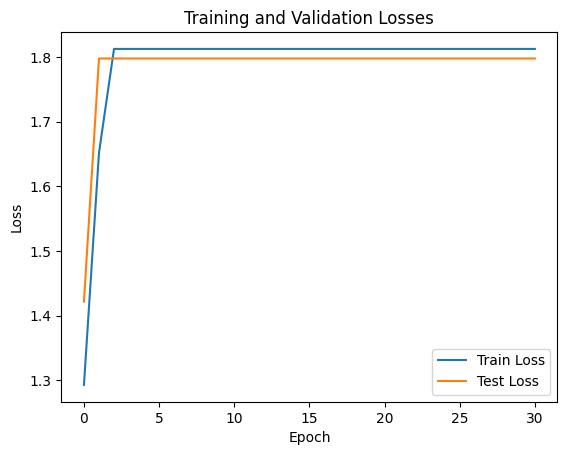

In [17]:
models = myDeeperNeuralNet(input_size)
best_model = training_loop(50, models, 0.004, 64)

Epoch 5 - Train Accuracy: 0.9904106435506022
Epoch 5 - Train Loss: 0.031113708218433806, Test Loss: 2.050205679182966
Epoch 5 - Test Accuracy: 0.7649929027679205
Epoch 10 - Train Accuracy: 0.9933239662467354
Epoch 10 - Train Loss: 0.021600384869129532, Test Loss: 1.9034402578140452
Epoch 10 - Test Accuracy: 0.7659687721788503
Epoch 15 - Train Accuracy: 0.9946734617735546
Epoch 15 - Train Loss: 0.017076144946230228, Test Loss: 1.9620516286693281
Epoch 15 - Test Accuracy: 0.765791341376863
Epoch 20 - Train Accuracy: 0.9953085184920578
Epoch 20 - Train Loss: 0.014542519063096686, Test Loss: 2.0694623077050824
Epoch 20 - Test Accuracy: 0.7653921220723917
Epoch 25 - Train Accuracy: 0.9957768728219539
Epoch 25 - Train Loss: 0.012778537858318074, Test Loss: 2.1857440310395813
Epoch 25 - Test Accuracy: 0.7680535841022001
Epoch 30 - Train Accuracy: 0.9958721313297294
Epoch 30 - Train Loss: 0.011986841049296402, Test Loss: 2.230606662399708
Epoch 30 - Test Accuracy: 0.7671220723917672
Early stop

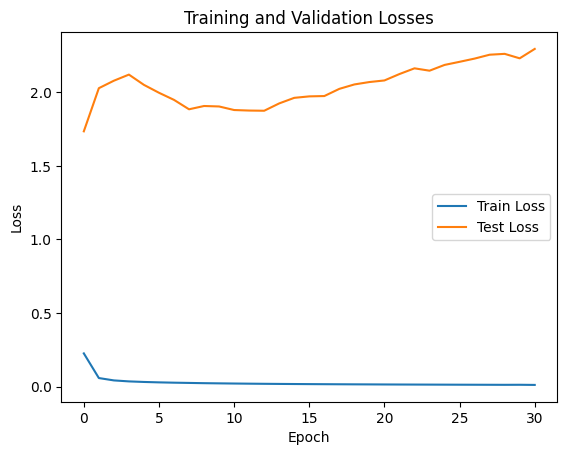

In [24]:
# Try CNN
class DeepCNN(nn.Module):
    def __init__(self, input_dim):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * (input_dim // 16), 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 5)
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
input_size = x_train.shape[1]    
models = DeepCNN(input_size)
best_model = training_loop(50, models, 0.00004, 64)
